# Word Embeddings 🧠

## Table of Contents
1. [Introduction](#introduction)
2. [Why Word Embeddings?](#why-embeddings)
3. [Types of Word Embeddings](#types)
4. [Word2Vec](#word2vec)
5. [GloVe](#glove)
6. [FastText](#fasttext)
7. [Practical Implementation](#implementation)
8. [Visualization](#visualization)
9. [Applications](#applications)
10. [Limitations and Best Practices](#limitations)
11. [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>

**Word embeddings** are dense vector representations of words in a continuous vector space. They are one of the most fundamental concepts in Natural Language Processing (NLP) and have revolutionized how machines understand and process human language.

In simple terms, word embeddings convert words (categorical data) into numerical vectors where semantically similar words have similar representations. This allows machine learning models to understand relationships between words and capture semantic meaning.

### Key Properties of Word Embeddings:
- **Dense representations**: Unlike sparse one-hot encodings, embeddings are dense vectors (typically 50-300 dimensions)
- **Semantic similarity**: Similar words have similar vectors
- **Dimensionality reduction**: Compress vocabulary into lower-dimensional space
- **Arithmetic properties**: Support operations like `king - man + woman ≈ queen`

In [ ]:
# Install required packages
!pip install gensim numpy matplotlib scikit-learn pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.4 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Why Word Embeddings? <a name="why-embeddings"></a>

### The Problem with Traditional Representations

Before word embeddings, the most common way to represent words was through **one-hot encoding**:

```
Vocabulary: ["cat", "dog", "bird", "fish"]

cat  = [1, 0, 0, 0]
dog  = [0, 1, 0, 0]
bird = [0, 0, 1, 0]
fish = [0, 0, 0, 1]
```

### Problems with One-Hot Encoding:
1. **High dimensionality**: Vector size = vocabulary size (can be millions)
2. **Sparsity**: Vectors are mostly zeros
3. **No semantic information**: All words are equally distant from each other
4. **No relationships**: Cannot capture that "cat" and "dog" are more similar than "cat" and "car"

In [3]:
# Demonstrate one-hot encoding limitations
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

words = ['cat', 'dog', 'bird', 'fish']
encoder = OneHotEncoder(sparse_output=False)
one_hot = encoder.fit_transform(np.array(words).reshape(-1, 1))

print("One-Hot Encoding:")
for word, vector in zip(words, one_hot):
    print(f"{word:6s}: {vector}")

# Calculate cosine similarity
print("\nCosine Similarity Between Words (One-Hot):")
similarity_matrix = cosine_similarity(one_hot)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
print(similarity_df)
print("\n⚠️ Notice: All words are equally distant (similarity = 0)!")

One-Hot Encoding:
cat   : [0. 1. 0. 0.]
dog   : [0. 0. 1. 0.]
bird  : [1. 0. 0. 0.]
fish  : [0. 0. 0. 1.]

Cosine Similarity Between Words (One-Hot):
      cat  dog  bird  fish
cat   1.0  0.0   0.0   0.0
dog   0.0  1.0   0.0   0.0
bird  0.0  0.0   1.0   0.0
fish  0.0  0.0   0.0   1.0

⚠️ Notice: All words are equally distant (similarity = 0)!


### Word Embeddings Solution

Word embeddings solve these problems by:
- Creating **dense, low-dimensional** vectors (typically 50-300 dimensions)
- Capturing **semantic relationships** (similar words → similar vectors)
- Learning from **context** (words appearing in similar contexts are similar)
- Enabling **transfer learning** (pre-trained embeddings can be used across tasks)

## 3. Types of Word Embeddings <a name="types"></a>

### Main Categories:

1. **Frequency-Based Embeddings**
   - Count-based methods (e.g., TF-IDF, Co-occurrence matrices)
   - GloVe (Global Vectors)

2. **Prediction-Based Embeddings**
   - Word2Vec (CBOW and Skip-gram)
   - FastText

3. **Contextualized Embeddings** (Modern Approach)
   - BERT, GPT, ELMo
   - Generate different embeddings based on context
   - (Not covered in detail in this notebook)

### Comparison Overview:

| Method | Type | Strength | Weakness |
|--------|------|----------|----------|
| **Word2Vec** | Prediction | Fast, captures semantic relationships | Fixed vocabulary, no OOV handling |
| **GloVe** | Frequency | Uses global statistics, good performance | Requires pre-computing co-occurrence matrix |
| **FastText** | Prediction | Handles OOV words, morphology-aware | Larger model size |
| **BERT** | Contextual | Context-aware, state-of-the-art | Computationally expensive |

## 4. Word2Vec <a name="word2vec"></a>

**Word2Vec**, introduced by Mikolov et al. (2013), is one of the most popular word embedding techniques. It uses a shallow neural network to learn word representations.

### Two Architectures:

#### 4.1 CBOW (Continuous Bag of Words)
- **Predicts** the target word from surrounding context words
- Input: Context words → Output: Target word
- Example: `["the", "cat", "on", "mat"] → "sat"`
- **Faster** to train, better for frequent words

#### 4.2 Skip-gram
- **Predicts** context words given a target word
- Input: Target word → Output: Context words
- Example: `"sat" → ["the", "cat", "on", "mat"]`
- **Better** for rare words, more accurate representations

### Key Hyperparameters:
- **vector_size**: Dimensionality of embeddings (typically 100-300)
- **window**: Maximum distance between target and context words
- **min_count**: Minimum word frequency threshold
- **sg**: 0 for CBOW, 1 for Skip-gram
- **epochs**: Number of training iterations

In [4]:
# Sample corpus for demonstration
sample_corpus = [
    "the cat sat on the mat",
    "the dog sat on the log",
    "cats and dogs are animals",
    "the cat and dog are friends",
    "I love my cat and dog",
    "animals are beautiful creatures",
    "the cat chased the mouse",
    "dogs are loyal animals",
    "cats are independent animals",
    "the dog played in the park"
]

# Preprocess: tokenize sentences
tokenized_corpus = [sentence.lower().split() for sentence in sample_corpus]
print("Sample tokenized sentences:")
for i, tokens in enumerate(tokenized_corpus[:3]):
    print(f"{i+1}. {tokens}")

Sample tokenized sentences:
1. ['the', 'cat', 'sat', 'on', 'the', 'mat']
2. ['the', 'dog', 'sat', 'on', 'the', 'log']
3. ['cats', 'and', 'dogs', 'are', 'animals']


In [5]:
# Train Word2Vec model (Skip-gram)
word2vec_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,      # Dimensionality of word vectors
    window=5,             # Context window size
    min_count=1,          # Minimum word frequency
    sg=1,                 # 1 for skip-gram, 0 for CBOW
    epochs=100,           # Number of training epochs
    seed=42
)

print("Word2Vec Model Trained!")
print(f"Vocabulary size: {len(word2vec_model.wv)}")
print(f"Vector dimensionality: {word2vec_model.wv.vector_size}")

Word2Vec Model Trained!
Vocabulary size: 25
Vector dimensionality: 100


In [6]:
# Explore word vectors
word = "cat"
if word in word2vec_model.wv:
    vector = word2vec_model.wv[word]
    print(f"Word: '{word}'")
    print(f"Vector shape: {vector.shape}")
    print(f"First 10 dimensions: {vector[:10]}")

Word: 'cat'
Vector shape: (100,)
First 10 dimensions: [ 9.6176956e-03  5.8691660e-03 -3.4599216e-03  9.9493051e-03
 -7.1904440e-05  8.7939050e-05 -1.9374330e-03 -7.4638724e-03
  8.0967359e-03 -1.0534187e-02]


In [7]:
# Find similar words
print("Words most similar to 'cat':")
similar_words = word2vec_model.wv.most_similar('cat', topn=5)
for word, score in similar_words:
    print(f"  {word}: {score:.4f}")

Words most similar to 'cat':
  dog: 0.1389
  and: 0.1039
  mat: 0.1037
  in: 0.0782
  mouse: 0.0767


## 5. GloVe (Global Vectors) <a name="glove"></a>

**GloVe**, developed by Stanford researchers (Pennington et al., 2014), combines the benefits of:
- **Global matrix factorization** methods (like LSA)
- **Local context window** methods (like Word2Vec)

### How GloVe Works:
1. **Construct co-occurrence matrix**: Count how often words appear together
2. **Optimize objective function**: Learn vectors that predict co-occurrence probabilities
3. **Key insight**: Ratios of co-occurrence probabilities encode meaning

### Advantages:
- Leverages **global corpus statistics**
- Often produces better word analogies than Word2Vec
- Pre-trained vectors available (trained on billions of tokens)

### Using Pre-trained GloVe:
GloVe vectors are typically used pre-trained. You can download them from:
- Stanford NLP: https://nlp.stanford.edu/projects/glove/
- Common versions: 50d, 100d, 200d, 300d (dimensions)

In [ ]:
# Example: Loading pre-trained GloVe embeddings

def load_glove_embeddings(file_path):
    """
    Load GloVe embeddings from file.

    Args:
        file_path: Path to GloVe file (e.g., 'glove.6B.100d.txt')

    Returns:
        Dictionary mapping words to vectors
    """
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Download GloVe 6B (trained on Wikipedia 2014 + Gigaword 5) 50d vectors
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Example usage:
glove_embeddings = load_glove_embeddings('glove.6B.50d.txt')
print(f"\nLoaded {len(glove_embeddings)} word vectors from glove.6B.50d.txt")

# Access a word vector
example_word = 'king'
if example_word in glove_embeddings:
    print(f"Vector for '{example_word}': {glove_embeddings[example_word][:10]}...")
else:
    print(f"Word '{example_word}' not found in GloVe vocabulary.")

example_word = 'queen'
if example_word in glove_embeddings:
    print(f"Vector for '{example_word}': {glove_embeddings[example_word][:10]}...")
else:
    print(f"Word '{example_word}' not found in GloVe vocabulary.")

--2025-11-08 12:39:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-08 12:39:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-08 12:39:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### Word Arithmetic with GloVe Embeddings

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def glove_analogy(word1, word2, word3, embeddings_dict, topn=3):
    """
    Solves a word analogy using GloVe embeddings: word1 is to word2 as word3 is to ?
    (e.g., king is to man as queen is to woman -> 'woman' = 'king' - 'man' + 'queen')

    Args:
        word1, word2, word3: Words in the analogy (word1 - word2 + word3)
        embeddings_dict: Dictionary mapping words to their GloVe vectors
        topn: Number of most similar words to return

    Returns:
        List of (word, similarity_score) tuples, or empty list if words not found.
    """
    # Ensure all words are in the vocabulary
    if not (word1 in embeddings_dict and word2 in embeddings_dict and word3 in embeddings_dict):
        print(f"Warning: One or more words ('{word1}', '{word2}', '{word3}') not found in GloVe vocabulary.")
        return []

    # Get the vectors
    vec1 = embeddings_dict[word1]
    vec2 = embeddings_dict[word2]
    vec3 = embeddings_dict[word3]

    # Perform the vector arithmetic: vector_result = vec1 - vec2 + vec3
    # Note: For king - man + woman = queen, it's typically: vec_queen = vec_king - vec_man + vec_woman
    result_vector = vec1 - vec2 + vec3

    # Calculate cosine similarity with all other words in the vocabulary
    similarities = {}
    for word, vector in embeddings_dict.items():
        if word not in [word1, word2, word3]: # Exclude the input words from results
            # Reshape vectors for cosine_similarity function (needs 2D arrays)
            similarity = cosine_similarity(result_vector.reshape(1, -1), vector.reshape(1, -1))[0][0]
            similarities[word] = similarity

    # Sort by similarity and return topn results
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_similarities[:topn]

print("GloVe Word Arithmetic: king - man + woman")
analogy_results_king = glove_analogy('king', 'man', 'woman', glove_embeddings, topn=5)
if analogy_results_king:
    print(f"  king - man + woman = ?")
    for word, score in analogy_results_king:
        print(f"  → {word}: {score:.4f}")
else:
    print("  Could not perform analogy. Check if words are in vocabulary or if dictionary is loaded.")


GloVe Word Arithmetic: king - man + woman
  king - man + woman = ?
  → queen: 0.8610
  → daughter: 0.7685
  → prince: 0.7641
  → throne: 0.7635
  → princess: 0.7513


## 6. FastText <a name="fasttext"></a>

**FastText**, developed by Facebook AI Research (2016), extends Word2Vec with an important innovation: **subword information**.

### Key Innovation: Character N-grams
Instead of treating words as atomic units, FastText represents each word as a bag of character n-grams.

Example for word "apple" with n-grams of length 3:
```
Full word: <apple>
Trigrams: <ap, app, ppl, ple, le>
```

### Advantages:
1. **Handles Out-of-Vocabulary (OOV) words**: Can generate vectors for words not seen during training
2. **Morphology-aware**: Captures prefixes, suffixes, and roots
3. **Better for rare words**: Uses subword information
4. **Language flexibility**: Works well for morphologically rich languages

### Use Cases:
- Languages with rich morphology (German, Turkish, Finnish)
- Domains with many rare/technical terms
- Applications needing OOV handling

In [10]:
# Train FastText model
fasttext_model = FastText(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,              # Skip-gram
    epochs=100,
    min_n=3,           # Minimum character n-gram length
    max_n=6,           # Maximum character n-gram length
    seed=42
)

print("FastText Model Trained!")
print(f"Vocabulary size: {len(fasttext_model.wv)}")
print(f"Vector dimensionality: {fasttext_model.wv.vector_size}")

FastText Model Trained!
Vocabulary size: 25
Vector dimensionality: 100


In [11]:
# Demonstrate OOV handling
print("Testing Out-of-Vocabulary (OOV) words:\n")

# Word in vocabulary
in_vocab_word = "cat"
print(f"In-vocabulary word: '{in_vocab_word}'")
print(f"Vector (first 5 dims): {fasttext_model.wv[in_vocab_word][:5]}")

# Word NOT in vocabulary (but similar to "cats")
oov_word = "kitten"
print(f"\nOut-of-vocabulary word: '{oov_word}'")
print(f"Vector (first 5 dims): {fasttext_model.wv[oov_word][:5]}")
print("\n✅ FastText can generate vectors for unseen words!")

# Compare with Word2Vec (would fail for OOV)
print(f"\nWord2Vec with '{oov_word}':")
if oov_word in word2vec_model.wv:
    print(f"Vector: {word2vec_model.wv[oov_word][:5]}")
else:
    print("❌ KeyError: Word not in vocabulary")

Testing Out-of-Vocabulary (OOV) words:

In-vocabulary word: 'cat'
Vector (first 5 dims): [-0.00068519 -0.00013909 -0.00077097 -0.00101988 -0.00285189]

Out-of-vocabulary word: 'kitten'
Vector (first 5 dims): [ 0.00046184 -0.0015436   0.00038852  0.00067407  0.00264114]

✅ FastText can generate vectors for unseen words!

Word2Vec with 'kitten':
❌ KeyError: Word not in vocabulary


## 7. Practical Implementation with Pre-trained Embeddings <a name="implementation"></a>

In this section, we'll work with **pre-trained GloVe embeddings** trained on massive corpora (6 billion tokens from Wikipedia and Gigaword). These embeddings have learned rich semantic representations from extensive text data, making them ideal for exploring word relationships and downstream applications.

Pre-trained embeddings offer several advantages:
- **Rich semantic knowledge**: Trained on billions of tokens
- **Ready to use**: No training required
- **Transfer learning**: Can be fine-tuned for specific tasks
- **Consistent quality**: Well-tested and validated

We'll download and load GloVe embeddings, then explore their capabilities through various experiments.

In [12]:
# Download pre-trained GloVe embeddings (if not already downloaded)
import os

if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip
    print("Download complete!")
else:
    print("GloVe embeddings already downloaded.")

GloVe embeddings already downloaded.


In [13]:
def load_glove_embeddings(file_path, max_words=None):
    """
    Load GloVe embeddings from file into memory.

    Args:
        file_path: Path to GloVe file (e.g., 'glove.6B.100d.txt')
        max_words: Maximum number of words to load (None = load all)

    Returns:
        Dictionary mapping words to their embedding vectors
    """
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_words and i >= max_words:
                break
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings (100-dimensional)
print("Loading GloVe embeddings...")
glove = load_glove_embeddings('glove.6B.100d.txt')
embedding_dim = len(next(iter(glove.values())))

print(f"✓ Loaded {len(glove):,} word vectors")
print(f"✓ Embedding dimensionality: {embedding_dim}")
print(f"\nSample words: {list(glove.keys())[:10]}")

Loading GloVe embeddings...
✓ Loaded 400,000 word vectors
✓ Embedding dimensionality: 100

Sample words: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]


In [14]:
# Utility functions for working with GloVe embeddings

def cosine_similarity_words(word1, word2, embeddings):
    """
    Calculate cosine similarity between two words.

    Cosine similarity measures the cosine of the angle between two vectors.
    Values range from -1 (opposite) to 1 (identical), with 0 meaning orthogonal.
    """
    if word1 not in embeddings or word2 not in embeddings:
        return None
    vec1 = embeddings[word1]
    vec2 = embeddings[word2]
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

def most_similar(word, embeddings, topn=10, exclude=None):
    """
    Find the most similar words to a given word based on cosine similarity.

    Args:
        word: Target word
        embeddings: Dictionary of word embeddings
        topn: Number of similar words to return
        exclude: Set of words to exclude from results

    Returns:
        List of (word, similarity_score) tuples
    """
    if word not in embeddings:
        return []

    if exclude is None:
        exclude = set()
    exclude.add(word)  # Always exclude the query word itself

    word_vec = embeddings[word].reshape(1, -1)
    similarities = []

    for other_word, other_vec in embeddings.items():
        if other_word not in exclude:
            sim = cosine_similarity(word_vec, other_vec.reshape(1, -1))[0][0]
            similarities.append((other_word, sim))

    # Sort by similarity (descending) and return top-n
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:topn]

def analogy(word1, word2, word3, embeddings, topn=5):
    """
    Solve word analogies: word1 is to word2 as word3 is to ?

    Uses vector arithmetic: result = word2 - word1 + word3
    Example: king - man + woman ≈ queen

    Args:
        word1, word2, word3: Words in the analogy
        embeddings: Dictionary of word embeddings
        topn: Number of candidates to return

    Returns:
        List of (word, similarity_score) tuples
    """
    if not all(w in embeddings for w in [word1, word2, word3]):
        return []

    # Perform vector arithmetic: word2 - word1 + word3
    result_vec = (embeddings[word2] - embeddings[word1] + embeddings[word3]).reshape(1, -1)

    # Exclude input words from results
    exclude = {word1, word2, word3}

    similarities = []
    for word, vec in embeddings.items():
        if word not in exclude:
            sim = cosine_similarity(result_vec, vec.reshape(1, -1))[0][0]
            similarities.append((word, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:topn]

print("✓ Utility functions defined")

✓ Utility functions defined


In [15]:
# Explore semantic relationships
print("=" * 60)
print("EXPLORING SEMANTIC RELATIONSHIPS")
print("=" * 60)

test_words = ['king', 'computer', 'beautiful', 'quickly', 'science']

for word in test_words:
    print(f"\n📍 Words most similar to '{word}':")
    similar = most_similar(word, glove, topn=5)
    for similar_word, score in similar:
        print(f"   {similar_word:15s} → {score:.4f}")

print("\n" + "=" * 60)

EXPLORING SEMANTIC RELATIONSHIPS

📍 Words most similar to 'king':
   prince          → 0.7682
   queen           → 0.7508
   son             → 0.7021
   brother         → 0.6986
   monarch         → 0.6978

📍 Words most similar to 'computer':
   computers       → 0.8752
   software        → 0.8373
   technology      → 0.7642
   pc              → 0.7366
   hardware        → 0.7290

📍 Words most similar to 'beautiful':
   lovely          → 0.8909
   gorgeous        → 0.8722
   wonderful       → 0.8081
   charming        → 0.7719
   magnificent     → 0.7332

📍 Words most similar to 'quickly':
   soon            → 0.8714
   immediately     → 0.8234
   again           → 0.8225
   eventually      → 0.8119
   finally         → 0.7946

📍 Words most similar to 'science':
   sciences        → 0.8073
   physics         → 0.7915
   institute       → 0.7663
   mathematics     → 0.7608
   studies         → 0.7590



In [16]:
# Calculate pairwise word similarities
print("=" * 60)
print("WORD PAIR SIMILARITY ANALYSIS")
print("=" * 60)
print("\nComparing semantic similarity between related and unrelated word pairs:\n")

word_pairs = [
    # Highly related pairs
    ('king', 'queen'),
    ('man', 'woman'),
    ('doctor', 'nurse'),
    ('car', 'automobile'),
    ('big', 'large'),
    # Moderately related pairs
    ('cat', 'dog'),
    ('food', 'restaurant'),
    ('computer', 'technology'),
    # Unrelated pairs
    ('happy', 'mountain'),
    ('science', 'pizza'),
    ('book', 'elephant')
]

for word1, word2 in word_pairs:
    sim = cosine_similarity_words(word1, word2, glove)
    if sim is not None:
        bar = '█' * int(sim * 20)  # Visual representation
        print(f"{word1:12s} ↔ {word2:12s} : {sim:.4f}  {bar}")

print("\n💡 Notice how semantically related words have higher similarity scores!")
print("=" * 60)

WORD PAIR SIMILARITY ANALYSIS

Comparing semantic similarity between related and unrelated word pairs:

king         ↔ queen        : 0.7508  ███████████████
man          ↔ woman        : 0.8323  ████████████████
doctor       ↔ nurse        : 0.7522  ███████████████
car          ↔ automobile   : 0.6832  █████████████
big          ↔ large        : 0.7082  ██████████████
cat          ↔ dog          : 0.8798  █████████████████
food         ↔ restaurant   : 0.5377  ██████████
computer     ↔ technology   : 0.7642  ███████████████
happy        ↔ mountain     : 0.2496  ████
science      ↔ pizza        : 0.0383  
book         ↔ elephant     : 0.1994  ███

💡 Notice how semantically related words have higher similarity scores!


## 8. Visualization <a name="visualization"></a>

Visualizing high-dimensional word embeddings helps us understand the geometric relationships between words. Since our embeddings are 100-dimensional, we need **dimensionality reduction** techniques to project them into 2D space for visualization.

We'll use two popular techniques:

### PCA (Principal Component Analysis)
- **Linear** dimensionality reduction technique
- Finds directions of maximum variance
- Fast and deterministic
- Good for understanding global structure

### t-SNE (t-Distributed Stochastic Neighbor Embedding)
- **Non-linear** dimensionality reduction technique
- Preserves local neighborhood structure
- Better at revealing clusters
- Slower and stochastic (different runs give different results)

Let's visualize different semantic categories to see how word embeddings cluster related concepts together.

In [17]:
# Select diverse words across different semantic categories
words_to_visualize = {
    'Royalty': ['king', 'queen', 'prince', 'princess', 'monarch', 'crown'],
    'Animals': ['cat', 'dog', 'bird', 'fish', 'lion', 'elephant'],
    'Colors': ['red', 'blue', 'green', 'yellow', 'black', 'white'],
    'Countries': ['france', 'germany', 'italy', 'spain', 'japan', 'china'],
    'Sports': ['football', 'basketball', 'tennis', 'baseball', 'soccer', 'cricket'],
    'Technology': ['computer', 'phone', 'internet', 'software', 'digital', 'technology']
}

# Flatten the dictionary and filter words that exist in embeddings
all_words = []
word_categories = []
category_colors = {
    'Royalty': '#FF6B6B',
    'Animals': '#4ECDC4',
    'Colors': '#FFE66D',
    'Countries': '#95E1D3',
    'Sports': '#F38181',
    'Technology': '#AA96DA'
}

for category, words in words_to_visualize.items():
    for word in words:
        if word in glove:
            all_words.append(word)
            word_categories.append(category)

# Get vectors for selected words
word_vectors = np.array([glove[word] for word in all_words])

print(f"Visualizing {len(all_words)} words across {len(words_to_visualize)} categories")
print(f"Original dimensionality: {word_vectors.shape[1]}D → Reducing to 2D\n")

Visualizing 36 words across 6 categories
Original dimensionality: 100D → Reducing to 2D



Applying PCA...


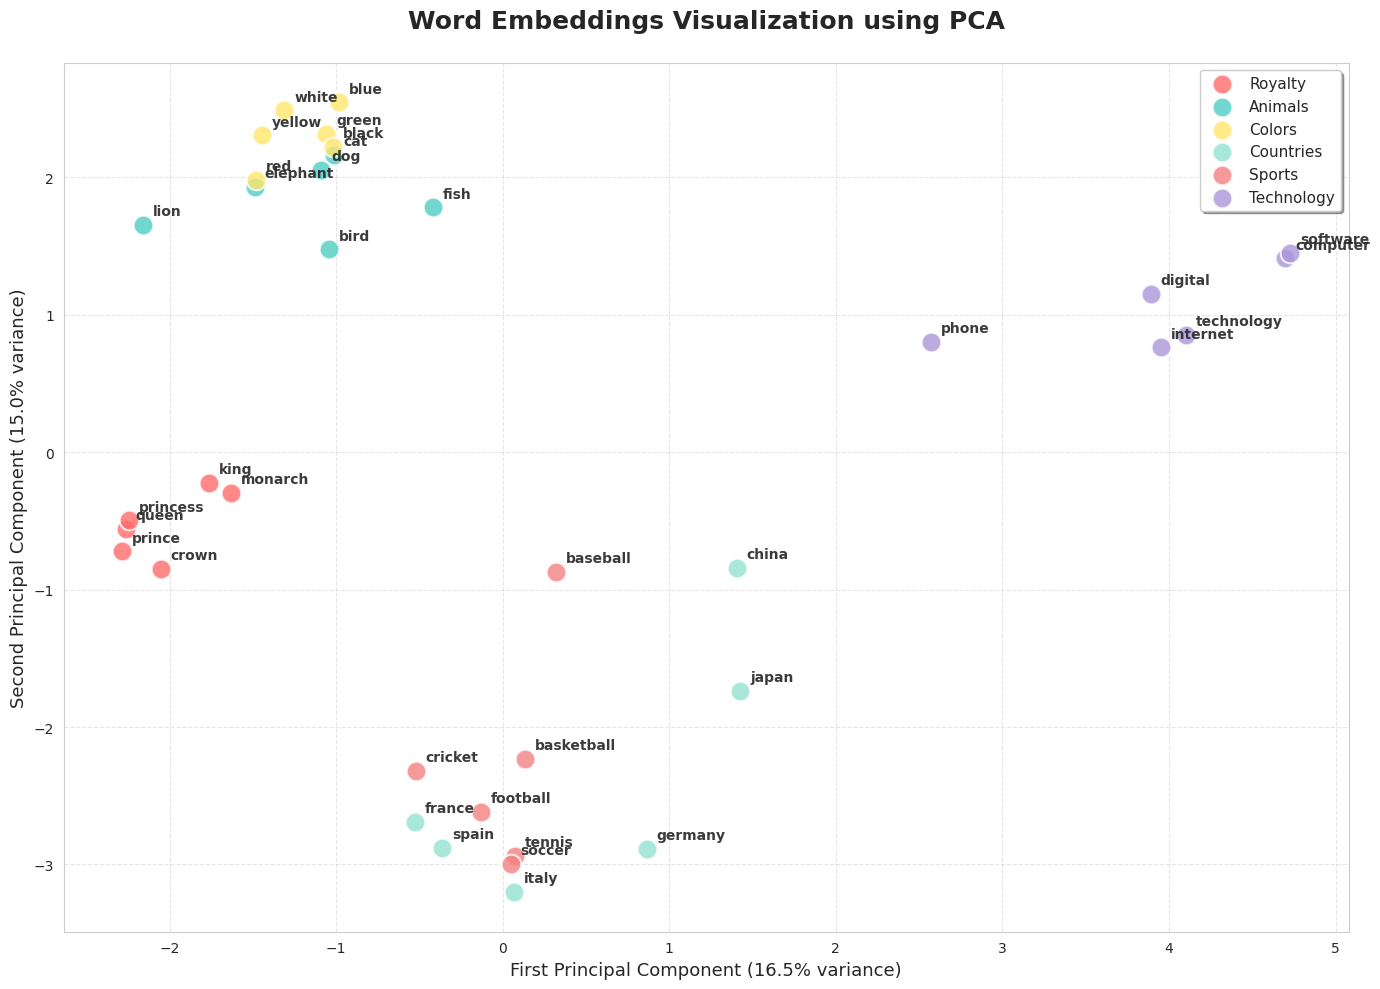


✓ PCA captures 31.4% of total variance in 2D
✓ Notice how semantically related words cluster together!


In [ ]:
# PCA Visualization
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
word_vectors_2d_pca = pca.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid") # Apply seaborn style

# Plot each category with different colors
for category in words_to_visualize.keys():
    mask = np.array([cat == category for cat in word_categories])
    plt.scatter(
        word_vectors_2d_pca[mask, 0],
        word_vectors_2d_pca[mask, 1],
        c=category_colors[category],
        label=category,
        alpha=0.8,
        s=200,
        edgecolors='white',
        linewidth=1.5
    )

# Add word labels
for i, word in enumerate(all_words):
    plt.annotate(
        word,
        xy=(word_vectors_2d_pca[i, 0], word_vectors_2d_pca[i, 1]),
        xytext=(7, 7),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        alpha=0.9
    )

plt.title('Word Embeddings Visualization using PCA', fontsize=18, fontweight='bold', pad=25)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=13)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=13)
plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n✓ PCA captures {sum(pca.explained_variance_ratio_):.1%} of total variance in 2D")
print("✓ Notice how semantically related words cluster together!")


Applying t-SNE (this may take a moment)...


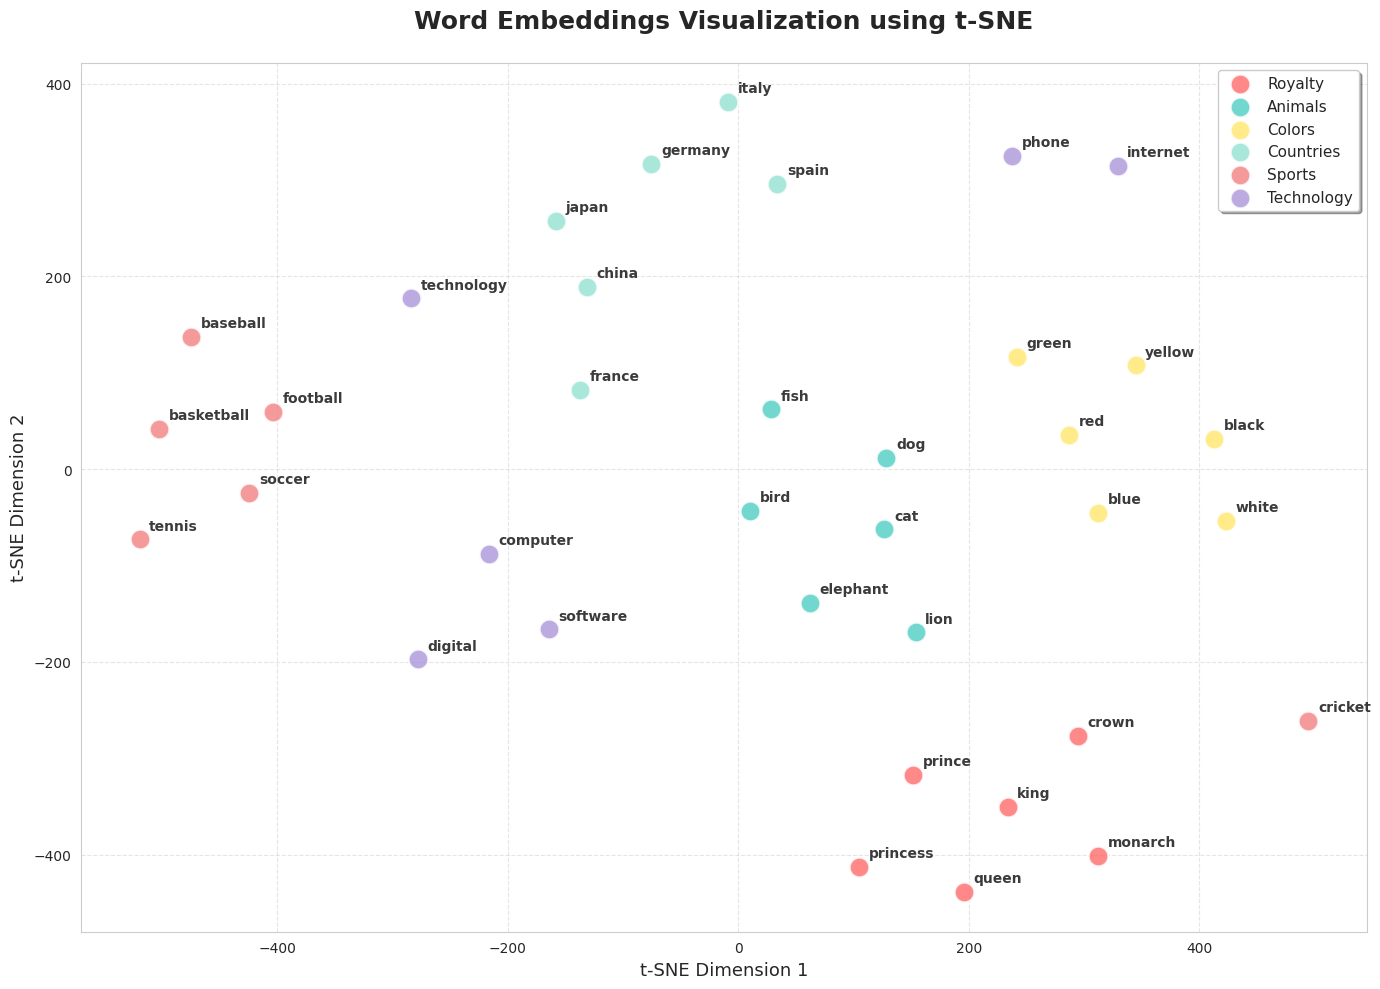


✓ t-SNE reveals tighter, more distinct clusters
✓ Non-linear reduction better preserves local neighborhoods


In [ ]:
# t-SNE Visualization
print("\nApplying t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000, learning_rate=200)
word_vectors_2d_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid") # Apply seaborn style

# Plot each category with different colors
for category in words_to_visualize.keys():
    mask = np.array([cat == category for cat in word_categories])
    plt.scatter(
        word_vectors_2d_tsne[mask, 0],
        word_vectors_2d_tsne[mask, 1],
        c=category_colors[category],
        label=category,
        alpha=0.8,
        s=200,
        edgecolors='white',
        linewidth=1.5
    )

# Add word labels
for i, word in enumerate(all_words):
    plt.annotate(
        word,
        xy=(word_vectors_2d_tsne[i, 0], word_vectors_2d_tsne[i, 1]),
        xytext=(7, 7),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        alpha=0.9
    )

plt.title('Word Embeddings Visualization using t-SNE', fontsize=18, fontweight='bold', pad=25)
plt.xlabel('t-SNE Dimension 1', fontsize=13)
plt.ylabel('t-SNE Dimension 2', fontsize=13)
plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ t-SNE reveals tighter, more distinct clusters")
print("✓ Non-linear reduction better preserves local neighborhoods")

## 9. Applications <a name="applications"></a>

Word embeddings are the foundation for many NLP applications. Beyond applications like semantic search and document similarity, embeddings can be used as a starting point for training deep learning models for NLP tasks:

### Creating Embedding Layers for Neural Networks

Pre-trained embeddings can be used to **initialize embedding layers** in deep learning models. This is a form of **transfer learning** that provides:

- Better starting point than random initialization
- Faster convergence during training
- Better performance, especially with limited data
- Semantic knowledge from large corpora

The embedding layer can be:
- **Frozen**: Keep pre-trained weights fixed
- **Fine-tuned**: Allow gradual updates during training

This is commonly used in:
- Text classification (sentiment analysis, spam detection)
- Named entity recognition
- Machine translation
- Question answering systems

## 10. Limitations and Best Practices <a name="limitations"></a>

While word embeddings are powerful, they have important limitations. Understanding these helps us use them appropriately and know when to consider alternatives.

### 10.1 Major Limitations

#### 1. **Context Independence (Polysemy Problem)**

Traditional embeddings like Word2Vec and GloVe assign **one vector per word**, regardless of context. This fails for words with multiple meanings:

- **"bank"**: financial institution vs. river bank
- **"bat"**: flying mammal vs. sports equipment
- **"apple"**: fruit vs. technology company

**Solution**: Use contextualized embeddings (BERT, GPT, ELMo) that generate different vectors based on surrounding words.

#### 2. **Bias and Fairness Issues**

Embeddings learn from real-world text, which contains societal biases. These biases are encoded in the geometric relationships between words.

**Examples of documented biases:**
- Gender bias: "programmer" closer to "man" than "woman"
- Racial bias: certain professions associated with particular ethnic groups
- Age bias: negative stereotypes about elderly

**Implications:**
- Can perpetuate discrimination in downstream applications
- Especially problematic in hiring, lending, and criminal justice systems

**Solutions:**
- Apply debiasing algorithms (e.g., removing gender subspace)
- Curate training data carefully
- Regular bias auditing
- Use bias-aware evaluation metrics

#### 3. **Out-of-Vocabulary (OOV) Problem**

Word2Vec and GloVe cannot handle words not seen during training:
- New words ("COVID-19", "blockchain")
- Misspellings
- Domain-specific terminology
- Rare words

**Solutions:**
- Use FastText (character n-gram based)
- Subword tokenization (BPE, WordPiece)
- Character-level models

#### 4. **Language and Domain Dependence**

Embeddings trained on one language/domain may not work well for others:
- English embeddings don't work for Chinese
- General-purpose embeddings may miss medical terminology
- Social media language differs from formal text

**Solutions:**
- Use language-specific embeddings
- Train or fine-tune on domain-specific corpora
- Consider multilingual embeddings for cross-lingual tasks

#### 5. **Lack of Interpretability**

Individual embedding dimensions don't have clear semantic meaning:
- Cannot say "dimension 42 represents gender"
- Black-box representations
- Difficult to debug or explain

**Mitigation:**
- Analyze through similarity and analogy tasks
- Use probing classifiers to understand what embeddings capture
- Visualize with dimensionality reduction

#### 6. **Static Nature**

Word meanings evolve over time, but static embeddings don't:
- "Tweet" acquired new meaning with Twitter
- Pandemic-related terms shifted in usage

**Solutions:**
- Periodically retrain embeddings
- Use temporal embeddings for diachronic analysis
- Monitor performance degradation over time

## 11. Conclusion <a name="conclusion"></a>

Word embeddings have revolutionized Natural Language Processing by providing dense, semantic vector representations of words. In this notebook, we've explored:

✓ **Fundamentals**: What embeddings are and why they're superior to one-hot encoding

✓ **Methods**: Word2Vec (CBOW, Skip-gram), GloVe, and FastText—each with unique strengths

✓ **Semantic Properties**: Embeddings capture meaning, enabling similarity search and analogical reasoning

✓ **Practical Applications**: From semantic search to document similarity to neural network initialization

✓ **Visualizations**: PCA and t-SNE reveal how embeddings cluster semantically related concepts

✓ **Limitations**: Context independence, bias issues, OOV problems, and lack of interpretability

### The Evolution: From Static to Contextual

While we've focused on static embeddings (Word2Vec, GloVe, FastText), the field has evolved:

**Traditional Embeddings (2013-2017):**
- One vector per word
- Fast and efficient
- Still valuable for many applications

**Contextual Embeddings (2018+):**
- **ELMo** (2018): Bi-directional LSTM-based
- **BERT** (2018): Transformer-based, masked language modeling
- **GPT** series (2018+): Auto-regressive language models
- **Modern variants**: RoBERTa, ALBERT, DeBERTa, etc.

**Advantages of Contextual Models:**
- Handle polysemy (different vectors for different contexts)
- State-of-the-art performance on most NLP tasks
- Better transfer learning capabilities